In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
import os
import progressbar
import openpyxl as xl
import statsmodels.tools as tools
import scipy.stats as stats

# Wczytanie danych, dodanie wyrazu wolnego, ustalenie Y i X

### Dane:
- *GST* - Global Surface Temperature
    * średnia temperatura powierzchni Ziemi w latach 1960-2023. Jest obliczana jako średnia ważona temperatury wody oceanu i powietrza nad lądami
    * https://climate.nasa.gov/vital-signs/global-temperature/?intent=121
- *CO2*
    * Emisje dwutlenku węgla (CO₂) z paliw kopalnych i przemysłu w latach 1960-2023. Zmiany sposobu użytkowania gleb (na przykład wylesianie i niszczenie lasów deszczowych) nie są uwzględnione
    * https://ourworldindata.org/co2-emissions
- *World_pop*
    * Populacja na świecie w latach 1960-2023
    * https://data.worldbank.org/indicator/SP.POP.TOTL
- *OHC* - Ocean Heat Change - USUNĄĆ
- *Sea_level*
    * średnia bezwzględna zmiana poziomu morza w calach, w latach 1960-2023, która odnosi się do wysokości powierzchni oceanu, niezależnie od tego, czy pobliski ląd podnosi się, czy opada
    * https://www.epa.gov/climate-indicators/climate-change-indicators-sea-level
- *Surf_temp* - USUNĄĆ

In [11]:
data = pd.read_excel('dane.xlsx')
data.set_index(['Year'], inplace = True)
data.head()

,GST,C02,World_pop,OHC,Sea_level,Surf_temp
Year,,,,,,
1960,-0.03,9.387010,3.021529e+09,-1.678233,4.503937,13.758788
1961,0.06,9.415042,3.062769e+09,-2.351233,4.748031,13.834421
1962,0.03,9.747287,3.117373e+09,-1.311233,4.543307,13.773865
1963,0.05,10.266772,3.184063e+09,-2.508233,4.480315,13.810860
1964,-0.20,10.824466,3.251253e+09,-3.357233,4.169291,13.598911


In [10]:
y = data[['GST']]  
x0 = pd.DataFrame(np.ones(y.shape), index = data.index, columns = ['const'])
X = pd.concat([x0, data[['GST', 'C02','World_pop','OHC','Sea_level','Surf_temp']]], axis = 1)

# wykres danych

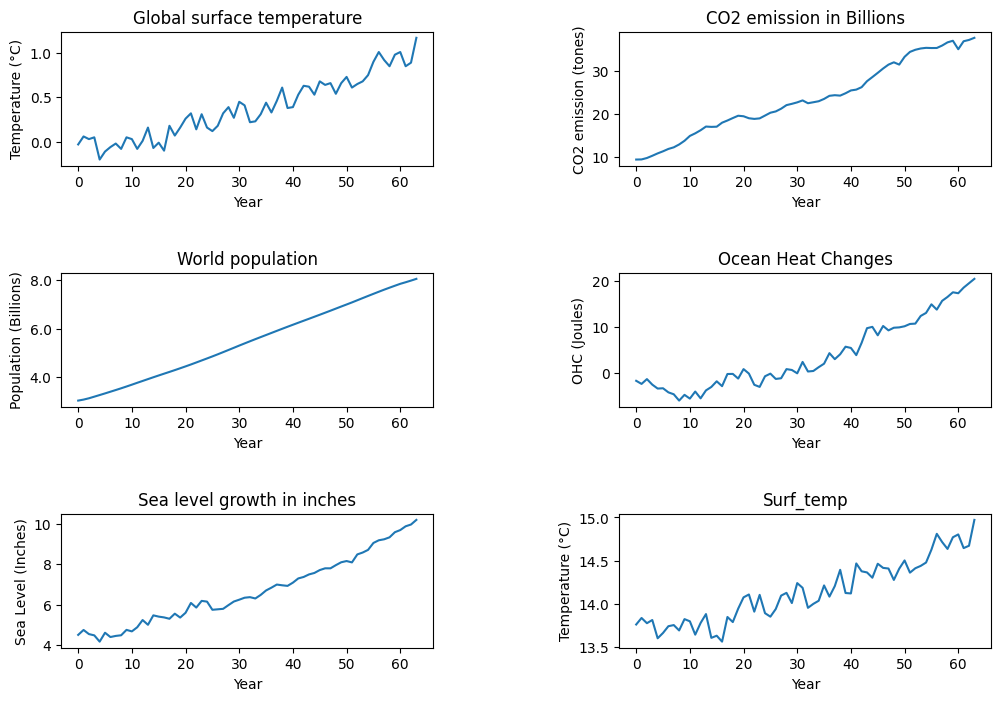

In [3]:
h = plt.figure(figsize=(12, 8))

# Pierwszy wykres: Global Surface Temperature
ax1 = plt.subplot2grid((3, 2), (0, 0))
hlp = np.array(range(y.shape[0]))
ax1.plot(hlp, y)
ax1.set_title('Global surface temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)')

# Drugi wykres: CO2 Emissions
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax2.plot(hlp, X.C02)
ax2.set_title('CO2 emission in Billions')
ax2.set_xlabel('Year')
ax2.set_ylabel('CO2 emission (tones)')

# Trzeci wykres: World Population
ax3 = plt.subplot2grid((3, 2), (1, 0)) 
ax3.plot(hlp, X.World_pop)
ax3.set_title('World population')
ax3.set_xlabel('Year')
ax3.set_ylabel('Population (Billions)')
def format_population(x, pos):
    'Funkcja do formatowania osi Y, skracając liczby do miliardów'
    if x >= 1e9:
        return f'{x*1e-9:.1f}'  # Zwracamy liczbę w miliardach z 1 miejscem po przecinku
    else:
        return f'{x:.0f}'

ax3.yaxis.set_major_formatter(plt.FuncFormatter(format_population)) 

# Czwarty wykres: Ocean Heat Changes
ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.plot(hlp, X.OHC)
ax4.set_title('Ocean Heat Changes')
ax4.set_xlabel('Year')
ax4.set_ylabel('OHC (Joules)')

# Piąty wykres: Sea Level Growth
ax5 = plt.subplot2grid((3, 2), (2, 0))
ax5.plot(hlp, X.Sea_level)
ax5.set_title('Sea level growth in inches')
ax5.set_xlabel('Year')
ax5.set_ylabel('Sea Level (Inches)')

# Szósty wykres: Surface Temperature
ax6 = plt.subplot2grid((3, 2), (2, 1)) 
ax6.plot(hlp, X.Surf_temp)
ax6.set_title('Surf_temp')
ax6.set_xlabel('Year')
ax6.set_ylabel('Temperature (°C)')

plt.subplots_adjust(hspace = 0.8, wspace=0.5)
plt.show()


# model liniowy ze wszystkimi zmiennymi

In [9]:

import math
model = sm.OLS(y, X).fit()     # <-- obiekt wyników; istnieje jeszcze obiekt modelu; obiekt wyników daje nam .fit(), bez tego byłby obiekt modelu
print(model.params)
print(model.cov_params())      # macierz kowariancji oszacowanych parametrów
model.summary()

const        5.425241e-07
GST          1.000000e+00
C02         -1.411755e-09
World_pop    2.987679e-17
OHC          1.691355e-16
Sea_level   -9.020562e-16
Surf_temp    3.885781e-16
dtype: float64
                  const           GST           C02     World_pop  \
const      1.277611e-09  1.084943e-10 -8.933756e-13  2.660379e-21   
GST        1.084943e-10  1.019084e-11 -6.707546e-14  1.108729e-22   
C02       -8.933756e-13 -6.707546e-14  6.768835e-15 -3.050153e-23   
World_pop  2.660379e-21  1.108729e-22 -3.050153e-23  2.611526e-31   
OHC       -7.687813e-14 -2.190132e-14  8.822436e-17  4.994541e-24   
Sea_level -2.744957e-13 -9.722824e-14 -7.162786e-15 -8.674862e-23   
Surf_temp -9.265135e-11 -7.825288e-12  6.879785e-14 -2.013386e-22   

                    OHC     Sea_level     Surf_temp  
const     -7.687813e-14 -2.744957e-13 -9.265135e-11  
GST       -2.190132e-14 -9.722824e-14 -7.825288e-12  
C02        8.822436e-17 -7.162786e-15  6.879785e-14  
World_pop  4.994541e-24 -8.674862e

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GST   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.348e+12
Date:                Thu, 22 May 2025   Prob (F-statistic):          8.89e-323
Time:                        17:18:02   Log-Likelihood:                 817.52
No. Observations:                  64   AIC:                            -1621.
Df Residuals:                      57   BIC:                            -1606.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.425e-07   3.57e-05      0.015      0.988    -7.1e-05    7.21e-05
GST            1.0000   3.19e-06   3.13e+05      0.000       1.000       1.000
C02        -1.412e-09   8.23e-08     -0.017      0.986   -1.66e-07    1.63e-07
World_pop   2.988e-17   5.11e-16      0.058      0.954   -9.93e-16    1.05e-15
OHC         1.691e-16   5.58e-08   3.03e-09      1.000   -1.12e-07    1.12e-07
Sea_level  -9.021e-16   4.59e-07  -1.96e-09      1.000   -9.19e-07    9.19e-07
Surf_temp   3.886e-16    2.6e-06    1.5e-10      1.000    -5.2e-06     5.2e-06
==============================================================================
Omnibus:                       21.452   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.325
Skew:                          -0.118   Prob(JB):                        0.115
Kurtosis:                       1.749   Cond. No.                     2.24e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# model liniowy z y jako surf_temp (bez GST i OHC)

In [5]:
data2 = pd.read_excel('dane2.xlsx')
data2.set_index(['Year'], inplace = True)
y2 = data2[['Surf_temp']]  
x0_2 = pd.DataFrame(np.ones(y.shape), index = data2.index, columns = ['const'])
X2 = pd.concat([x0_2, data2[['Surf_temp','C02','World_pop','OHC','Sea_level']]], axis = 1)
import math
model = sm.OLS(y2, X2).fit()     
print(model.params)
print(model.cov_params())      
model.summary()

const       -1.458695e-06
Surf_temp    1.000000e+00
C02          1.343739e-12
World_pop    9.129341e-17
OHC          6.730727e-16
Sea_level   -6.661338e-16
dtype: float64
                  const     Surf_temp           C02     World_pop  \
const      6.835064e-11 -5.209886e-12 -9.998538e-17  8.254343e-22   
Surf_temp -5.209886e-12  4.052684e-13  9.644390e-18 -6.480902e-23   
C02       -9.998538e-17  9.644390e-18  3.528941e-21 -1.660456e-26   
World_pop  8.254343e-22 -6.480902e-23 -1.660456e-26  1.449794e-31   
OHC        8.716684e-14 -3.402305e-15 -3.119307e-20  2.918489e-24   
Sea_level  4.242204e-13 -5.705087e-14 -4.351807e-18 -4.779220e-23   

                    OHC     Sea_level  
const      8.716684e-14  4.242204e-13  
Surf_temp -3.402305e-15 -5.705087e-14  
C02       -3.119307e-20 -4.351807e-18  
World_pop  2.918489e-24 -4.779220e-23  
OHC        1.711921e-15 -9.119677e-15  
Sea_level -9.119677e-15  1.170281e-13  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Surf_temp   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.510e+12
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        17:17:10   Log-Likelihood:                 835.65
No. Observations:                  64   AIC:                            -1659.
Df Residuals:                      58   BIC:                            -1646.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.459e-06   8.27e-06     -0.176      0.861    -1.8e-05    1.51e-05
Surf_temp      1.0000   6.37e-07   1.57e+06      0.000       1.000       1.000
C02         1.344e-12   5.94e-11      0.023      0.982   -1.18e-10     1.2e-10
World_pop   9.129e-17   3.81e-16      0.240      0.811   -6.71e-16    8.53e-16
OHC         6.731e-16   4.14e-08   1.63e-08      1.000   -8.28e-08    8.28e-08
Sea_level  -6.661e-16   3.42e-07  -1.95e-09      1.000   -6.85e-07    6.85e-07
==============================================================================
Omnibus:                       19.399   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.195
Skew:                          -0.130   Prob(JB):                        0.123
Kurtosis:                       1.773   Cond. No.                     6.93e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.93e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Histogramy i wykres rozrzutu

<function matplotlib.pyplot.show(close=None, block=None)>

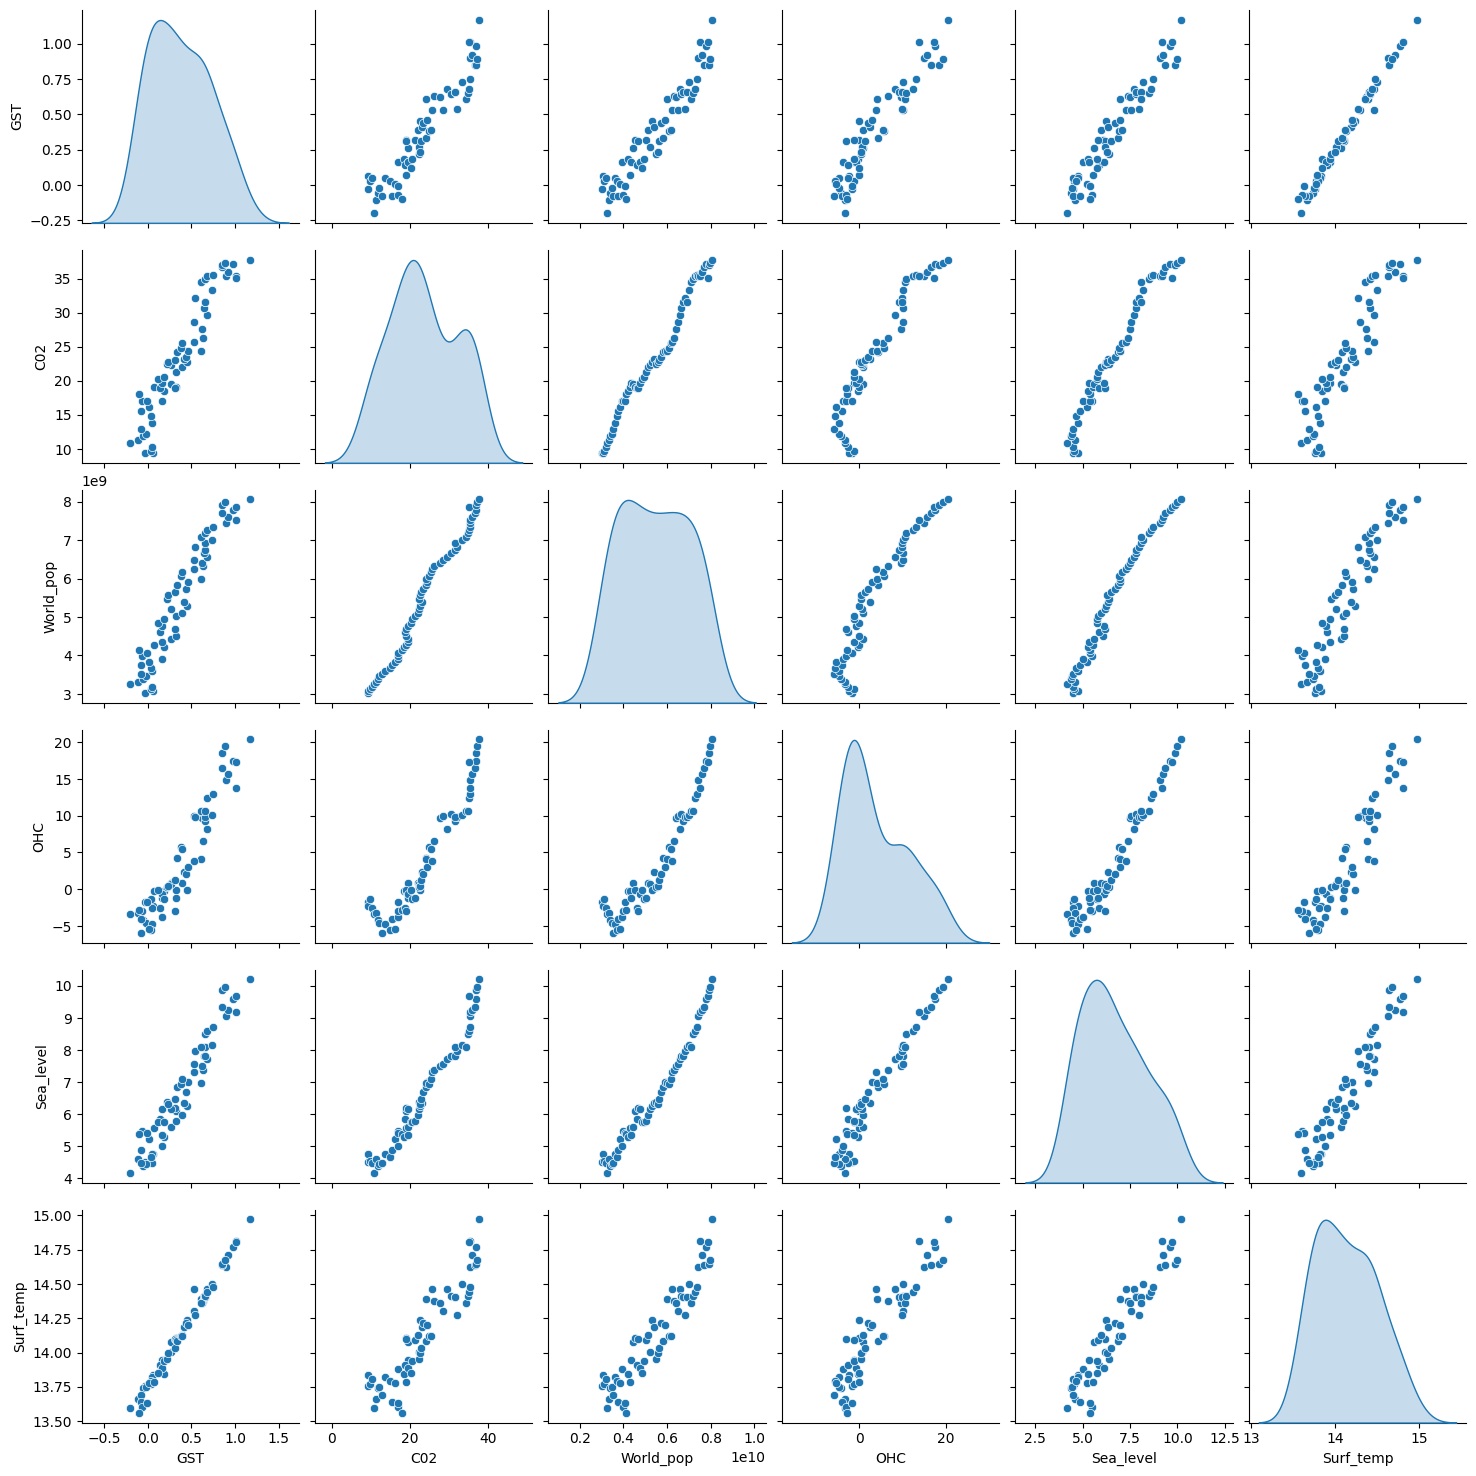

In [6]:
sb.pairplot(data, kind = 'scatter', diag_kind = 'kde', )
plt.show

# Próba predykcji za pomocą regresji liniowej kiedy i z jakim prawdopodobieństwem średni przrost temperatury przekroczy 1.5 za 15 lat (WORK IN PROGRESS)

const   -34.632687
x1        0.017580
dtype: float64
          const            x1
const  2.020898 -1.014675e-03
x1    -0.001015  5.095027e-07
                            OLS Regression Results                            
Dep. Variable:                    GST   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     606.6
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.02e-33
Time:                        17:17:14   Log-Likelihood:                 54.151
No. Observations:                  64   AIC:                            -104.3
Df Residuals:                      62   BIC:                            -99.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

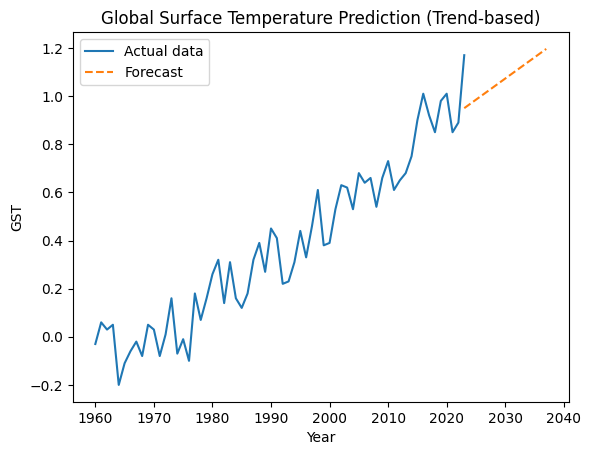

In [7]:
X_yr = np.array(data.index).reshape(-1, 1)  # Lata jako zmienna niezależna
X_yr = sm.add_constant(X_yr)  # Dodanie stałej (intercept) do modelu

# Tworzymy model OLS dla samego trendu zmiennej 'y' (np. 'GST')
model = sm.OLS(y, X_yr).fit()

# Wyświetlamy parametry modelu
print(model.params)
print(model.cov_params())  # Macierz kowariancji oszacowanych parametrów
print(model.summary())

# Przygotowanie danych do prognozy
# Stwórzmy dane na 15 przyszłych lat
years_to_predict = np.array([2023 + i for i in range(1, 16)]).reshape(-1, 1)  # Lata na 15 kolejnych lat
years_to_predict_const = sm.add_constant(years_to_predict)  # Dodanie stałej (intercept) do nowych lat

# Przewidywanie wartości 'y' na 15 lat na podstawie samego trendu
predictions = model.predict(years_to_predict_const)
print("Prognozy na lata 2023-2037:", predictions)

# Obliczanie prawdopodobieństwa, że y > 1.5 w ciągu 15 lat
threshold = 1.5
# Błąd standardowy przewidywanych wartości na podstawie macierzy kowariancji
std_errors = np.sqrt(np.diag(model.cov_params()))  # Błąd standardowy dla prognozowanych wartości

# Prawdopodobieństwo, że y > 1.5
probability = 1 - stats.norm.cdf(threshold, loc=predictions[-1], scale=std_errors[-1])  # P(y > 1.5)

print(f'Prawdopodobieństwo, że wartość y przekroczy 1.5 w ciągu 15 lat: {probability:.4f}')

# Wizualizacja wyników
plt.plot(data.index, y, label='Actual data')
plt.plot(range(2023, 2038), predictions, label='Forecast', linestyle='--')
plt.xlabel('Year')
plt.ylabel('GST')
plt.title('Global Surface Temperature Prediction (Trend-based)')
plt.legend()
plt.show()

# Predykcja jako szereg czasowy

- sprawdzić niestacjonarność i autoregresyjność
- olać sezonowość
- ARMA 0, 1 lub 2 - 6 opcji do wyboru bo prawdopodobnie będzie niestacjonarny
- analizujemy zmienne egzogeniczne w kontekście procesu dynamicznego